In [144]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import SQLusername
from config import SQLpassword
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_tree, plot_importance, cv
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn import tree
pd.set_option('max_columns', None)

In [2]:
server = "cohort50sqlserver.database.windows.net" 
database = 'Illidans_Ingenious_Infrastructure' 
username = SQLusername 
password = SQLpassword  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = "SELECT * FROM dbo.boroughs_housing;"
df = pd.read_sql(query, cnxn)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113589 entries, 0 to 1113588
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   BOROUGH                    1113589 non-null  object        
 1   NEIGHBORHOOD               1113589 non-null  object        
 2   BUILDING CLASS CATEGORY    1113589 non-null  object        
 3   TAX CLASS AT PRESENT       1113589 non-null  object        
 4   BLOCK                      1113589 non-null  object        
 5   LOT                        1113589 non-null  object        
 6   ZIP CODE                   1113570 non-null  object        
 7   RESIDENTIAL UNITS          1113589 non-null  object        
 8   COMMERCIAL UNITS           1113589 non-null  object        
 9   TOTAL UNITS                1113589 non-null  object        
 10  LAND SQUARE FEET           647083 non-null   float64       
 11  GROSS SQUARE FEET          636337 non

In [17]:
# qqq['BUILDING CLASS CATEGORY NUMBER'] = qqq['BUILDING CLASS CATEGORY'].str[0:2]

In [5]:
# df['GROSS SQUARE FEET'].value_counts()

In [288]:
qqq[qqq['TOTAL UNITS'].isna()]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING CLASS CATEGORY NUMBER,YEAR,MONTH,DAY
882578,4,SPRINGFIELD GARDENS,02 TWO FAMILY DWELLINGS,4,13273,19,11434,-,-,NaN,8000.0,900.0,1931,1,730000.0,2016-11-22,02,2016,11,22


In [289]:
qqq = df.copy()
# qqq['BLOCK'] = pd.to_numeric(qqq['BLOCK'])
# qqq['LOT'] = pd.to_numeric(qqq['LOT'])
counts = qqq['NEIGHBORHOOD'].value_counts()
idx = counts[counts.lt(5000)].index
qqq.loc[qqq['NEIGHBORHOOD'].isin(idx), ['NEIGHBORHOOD']] = 'OTHER'
# qqq[qqq['NEIGHBORHOOD']=='OTHER']
qqq['BUILDING CLASS CATEGORY NUMBER'] = qqq['BUILDING CLASS CATEGORY'].str[0:2]
counts = qqq['BUILDING CLASS CATEGORY NUMBER'].value_counts()
idx = counts[counts.lt(18000)].index
qqq.loc[qqq['BUILDING CLASS CATEGORY NUMBER'].isin(idx), ['BUILDING CLASS CATEGORY NUMBER']] = 'COMMERCIAL'
# qqq[qqq['BUILDING CLASS CATEGORY']=='OTHER']
counts = qqq['ZIP CODE'].value_counts()
idx = counts[counts.lt(5000)].index
qqq.loc[qqq['ZIP CODE'].isin(idx), ['ZIP CODE']] = 'OTHER'
# qqq[qqq['ZIP CODE']=='OTHER']
# qqq['NEIGHBORHOOD'] = qqq['NEIGHBORHOOD'].str.strip()
qqq = qqq.astype({'SALE DATE': str})
qqq[['YEAR', 'MONTH', 'DAY']] = qqq['SALE DATE'].str.split("-", expand = True)
qqq = qqq.astype({'YEAR': int})
qqq = qqq[qqq['YEAR BUILT'].isna() != True]
qqq = qqq[qqq['YEAR BUILT']!="None"]
qqq = qqq.astype({'YEAR BUILT': int})

qqq['BUILDING CLASS CATEGORY NUMBER'] = qqq['BUILDING CLASS CATEGORY NUMBER'].replace({'10': 'COMMERCIAL',\
                    '13': 'COMMERCIAL','07': 'COMMERCIAL','09': 'COMMERCIAL','28': 'COMMERCIAL'}, regex=False)
qqq = qqq[qqq['BUILDING CLASS CATEGORY NUMBER'] != "COMMERCIAL"]

qqq.drop(882578, inplace = True)
qqq['TOTAL UNITS'] = qqq['TOTAL UNITS'].str.replace(',','', regex=False)
qqq['TOTAL UNITS'] = qqq['TOTAL UNITS'].str.replace('-','', regex=False)
qqq.replace(r'^\s*$', np.nan, regex=True, inplace = True)
qqq = qqq.astype({'TOTAL UNITS': int})
# Use misc/other for dummy --- feature shape mismatch
# NEIGHBORHOOD < 100, BUILDING CLASS CATEGORY < 100, ZIP CODE < 100, maybe...YEAR BUILT
# %10 year built for decades
# Split sale date by year and month
# Use actual train_test_split to see if splitting by year is the problem

In [290]:
qqq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533400 entries, 4 to 1113588
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   BOROUGH                         533400 non-null  object 
 1   NEIGHBORHOOD                    533400 non-null  object 
 2   BUILDING CLASS CATEGORY         533400 non-null  object 
 3   TAX CLASS AT PRESENT            533400 non-null  object 
 4   BLOCK                           533400 non-null  object 
 5   LOT                             533400 non-null  object 
 6   ZIP CODE                        533400 non-null  object 
 7   RESIDENTIAL UNITS               533400 non-null  object 
 8   COMMERCIAL UNITS                533400 non-null  object 
 9   TOTAL UNITS                     533400 non-null  int32  
 10  LAND SQUARE FEET                519742 non-null  float64
 11  GROSS SQUARE FEET               519537 non-null  float64
 12  YEAR BUILT     

In [401]:
qqq['TAX CLASS AT TIME OF SALE'].value_counts()

1    533400
Name: TAX CLASS AT TIME OF SALE, dtype: int64

In [402]:
training_data = qqq.loc[(qqq['SALE DATE'] < '2018-01-01')]
test_data = qqq.loc[(qqq['SALE DATE'] >= '2018-01-01')]
test_data.reset_index(drop=True,inplace=True)

In [403]:
X_train = training_data[['YEAR','LAND SQUARE FEET','GROSS SQUARE FEET', 'YEAR BUILT','TOTAL UNITS']]
# X_train = training_data[['SALE DATE']]
tmp = pd.get_dummies(training_data['BOROUGH'], prefix = 'BOROUGH', drop_first=True)
X_train = pd.concat([X_train, tmp], axis=1)
tmp = pd.get_dummies(training_data['TAX CLASS AT PRESENT'], prefix = 'TAX CLASS AT PRESENT', drop_first=True)
X_train = pd.concat([X_train, tmp], axis=1)
tmp = pd.get_dummies(training_data['NEIGHBORHOOD'], prefix = 'NEIGHBORHOOD', drop_first=True)
X_train = pd.concat([X_train, tmp], axis=1)
tmp = pd.get_dummies(training_data['BUILDING CLASS CATEGORY NUMBER'], prefix = 'BLDG', drop_first=True)
X_train = pd.concat([X_train, tmp], axis=1)
y_train = training_data[['SALE PRICE']]
X_test = test_data[['YEAR','LAND SQUARE FEET','GROSS SQUARE FEET', 'YEAR BUILT','TOTAL UNITS']]
# X_test = test_data[['SALE DATE']]
tmp = pd.get_dummies(test_data['BOROUGH'], prefix = 'BOROUGH', drop_first=True)
X_test = pd.concat([X_test, tmp], axis=1)
tmp = pd.get_dummies(test_data['TAX CLASS AT PRESENT'], prefix = 'TAX CLASS AT PRESENT', drop_first=True)
X_test = pd.concat([X_test, tmp], axis=1)
tmp = pd.get_dummies(test_data['NEIGHBORHOOD'], prefix = 'NEIGHBORHOOD', drop_first=True)
X_test = pd.concat([X_test, tmp], axis=1)
tmp = pd.get_dummies(test_data['BUILDING CLASS CATEGORY NUMBER'], prefix = 'BLDG', drop_first=True)
X_test = pd.concat([X_test, tmp], axis=1)
y_test = test_data[['SALE PRICE']]

In [404]:
X_train.drop(['NEIGHBORHOOD_FLATIRON'],axis=1,inplace=True)
X_train

,YEAR,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TOTAL UNITS,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_1D,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_4,NEIGHBORHOOD_BAY RIDGE,NEIGHBORHOOD_BAYCHESTER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BENSONHURST,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_COLLEGE POINT,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_CROWN HEIGHTS,NEIGHBORHOOD_CYPRESS HILLS,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_GLENDALE,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GRAVESEND,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HOLLIS,NEIGHBORHOOD_HOWARD BEACH,NEIGHBORHOOD_JACKSON HEIGHTS,NEIGHBORHOOD_LONG ISLAND CITY,NEIGHBORHOOD_MARINE PARK,NEIGHBORHOOD_MASPETH,NEIGHBORHOOD_MIDDLE VILLAGE,NEIGHBORHOOD_MIDTOWN EAST,NEIGHBORHOOD_MIDTOWN WEST,NEIGHBORHOOD_MIDWOOD,NEIGHBORHOOD_MORRISANIA/LONGWOOD,NEIGHBORHOOD_MURRAY HILL,NEIGHBORHOOD_NEW SPRINGVILLE,NEIGHBORHOOD_OAKLAND GARDENS,NEIGHBORHOOD_OCEAN HILL,NEIGHBORHOOD_OCEAN PARKWAY-NORTH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_OZONE PARK,NEIGHBORHOOD_PARK SLOPE,NEIGHBORHOOD_PARKCHESTER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_REGO PARK,NEIGHBORHOOD_RICHMOND HILL,NEIGHBORHOOD_RIDGEWOOD,NEIGHBORHOOD_RIVERDALE,NEIGHBORHOOD_ROSEDALE,NEIGHBORHOOD_SHEEPSHEAD BAY,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SOUNDVIEW,NEIGHBORHOOD_SOUTH JAMAICA,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_ST. ALBANS,NEIGHBORHOOD_SUNSET PARK,NEIGHBORHOOD_TRIBECA,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (96-116),NEIGHBORHOOD_WHITESTONE,NEIGHBORHOOD_WILLIAMSBRIDGE,NEIGHBORHOOD_WILLIAMSBURG-NORTH,NEIGHBORHOOD_WOODHAVEN,NEIGHBORHOOD_WOODSIDE,BLDG_02,BLDG_03,BLDG_04
4,2003,2134.0,3542.0,1899,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
26,2003,NaN,NaN,1986,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
532,2003,1393.0,2340.0,1930,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
535,2003,2469.0,5400.0,1901,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
538,2003,1564.0,3264.0,1910,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920399,2017,5775.0,2160.0,1994,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
920400,2017,2450.0,2500.0,1995,2,0,0,0,1,0,

In [405]:
X_test

,YEAR,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TOTAL UNITS,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_1D,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_4,NEIGHBORHOOD_BAY RIDGE,NEIGHBORHOOD_BAYCHESTER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BENSONHURST,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_COLLEGE POINT,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_CROWN HEIGHTS,NEIGHBORHOOD_CYPRESS HILLS,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_GLENDALE,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GRAVESEND,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HOLLIS,NEIGHBORHOOD_HOWARD BEACH,NEIGHBORHOOD_JACKSON HEIGHTS,NEIGHBORHOOD_LONG ISLAND CITY,NEIGHBORHOOD_MARINE PARK,NEIGHBORHOOD_MASPETH,NEIGHBORHOOD_MIDDLE VILLAGE,NEIGHBORHOOD_MIDTOWN EAST,NEIGHBORHOOD_MIDTOWN WEST,NEIGHBORHOOD_MIDWOOD,NEIGHBORHOOD_MORRISANIA/LONGWOOD,NEIGHBORHOOD_MURRAY HILL,NEIGHBORHOOD_NEW SPRINGVILLE,NEIGHBORHOOD_OAKLAND GARDENS,NEIGHBORHOOD_OCEAN HILL,NEIGHBORHOOD_OCEAN PARKWAY-NORTH,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_OZONE PARK,NEIGHBORHOOD_PARK SLOPE,NEIGHBORHOOD_PARKCHESTER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_REGO PARK,NEIGHBORHOOD_RICHMOND HILL,NEIGHBORHOOD_RIDGEWOOD,NEIGHBORHOOD_RIVERDALE,NEIGHBORHOOD_ROSEDALE,NEIGHBORHOOD_SHEEPSHEAD BAY,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SOUNDVIEW,NEIGHBORHOOD_SOUTH JAMAICA,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_ST. ALBANS,NEIGHBORHOOD_SUNSET PARK,NEIGHBORHOOD_TRIBECA,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (96-116),NEIGHBORHOOD_WHITESTONE,NEIGHBORHOOD_WILLIAMSBRIDGE,NEIGHBORHOOD_WILLIAMSBURG-NORTH,NEIGHBORHOOD_WOODHAVEN,NEIGHBORHOOD_WOODSIDE,BLDG_02,BLDG_03,BLDG_04
0,2018,987.0,2183.0,1860,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018,1883.0,5200.0,1900,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018,1370.0,4290.0,1970,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,1510.0,3072.0,1910,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018,2162.0,3600.0,1901,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120857,2022,3713.0,2059.0,2014,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
120858,2022,3713.0,1550.0,2018,2,0,0,0,1,0,0,

In [442]:
xgb_model = XGBRegressor(n_estimators = 1000, eta = 0.1, objective='reg:squarederror',random_state=42,\
                         max_depth = 7, verbosity = 0, gamma = 20, early_stopping_rounds=100,\
                        reg_lambda = 20, reg_alpha = 20)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose = False)
print("Training set accuracy score:",xgb_model.score(X_train,y_train))
y_pred = xgb_model.predict(X_test.values)
print("Test set accuracy score:",xgb_model.score(X_test,y_test))

Training set accuracy score: 0.7871218167779213


C:\Users\Prateek Bardhan\Anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Test set accuracy score: 0.5011761268182955


In [443]:
X_test_2018 = X_test[X_test['YEAR']==2018]
test_data_2018 = test_data[test_data['YEAR']==2018]
y_test_2018 = test_data_2018['SALE PRICE']

X_test_2019 = X_test[X_test['YEAR']==2019]
test_data_2019 = test_data[test_data['YEAR']==2019]
y_test_2019 = test_data_2019['SALE PRICE']

X_test_2020 = X_test[X_test['YEAR']==2020]
test_data_2020 = test_data[test_data['YEAR']==2020]
y_test_2020 = test_data_2020['SALE PRICE']

X_test_2021 = X_test[X_test['YEAR']==2021]
test_data_2021 = test_data[test_data['YEAR']==2021]
y_test_2021 = test_data_2021['SALE PRICE']

X_test_2022 = X_test[X_test['YEAR']==2022]
test_data_2022 = test_data[test_data['YEAR']==2022]
y_test_2022 = test_data_2022['SALE PRICE']

In [444]:
print("2018 test set accuracy score:",xgb_model.score(X_test_2018,y_test_2018))
print("2019 test set accuracy score:",xgb_model.score(X_test_2019,y_test_2019))
print("2020 test set accuracy score:",xgb_model.score(X_test_2020,y_test_2020))
print("2021 test set accuracy score:",xgb_model.score(X_test_2021,y_test_2021))
print("2022 test set accuracy score:",xgb_model.score(X_test_2022,y_test_2022))

2018 test set accuracy score: 0.7254596995904978
2019 test set accuracy score: 0.3310163553396869
2020 test set accuracy score: 0.3229380523634683
2021 test set accuracy score: 0.6503291853551829
2022 test set accuracy score: 0.6612391834916569


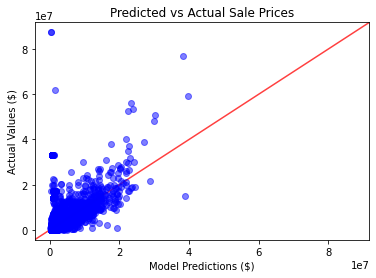

In [336]:
fig, ax = plt.subplots();
plt.scatter(y_pred,y_test, color='b', alpha = 0.5);
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r', alpha=0.75, zorder=0);
ax.set_xlim(lims);
ax.set_ylim(lims);
ax.set_xlabel("Model Predictions ($)");
ax.set_ylabel("Actual Values ($)");
ax.set_title("Predicted vs Actual Sale Prices");

In [474]:
qqq['SALE PRICE'].sort_values(ascending=False).head(15)
# REMOVE OUTLIERS!!!

1022488    87400000.0
1022487    87400000.0
980251     77100000.0
1031700    62000000.0
1053468    59000000.0
1086762    56000000.0
1053489    53500000.0
278342     53000000.0
1086988    52750000.0
741686     51000000.0
1053469    51000000.0
360994     50000000.0
414342     49000000.0
435343     49000000.0
589223     48000000.0
Name: SALE PRICE, dtype: float64

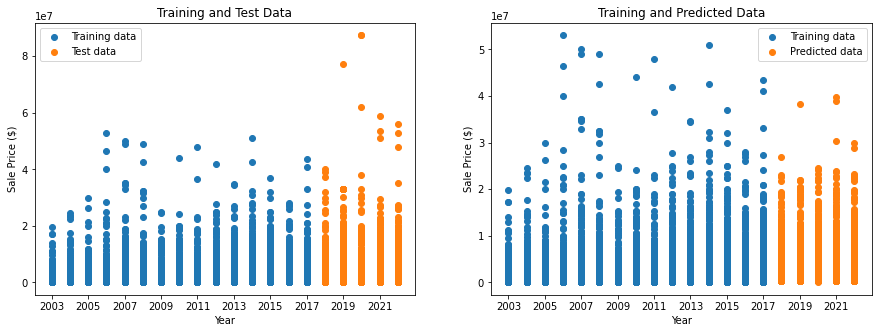

In [377]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5));
xticks = []
for i in range(2003,2023,2):
    xticks.append(i)

ax1.scatter(X_train['YEAR'],y_train, label='Training data');
ax1.scatter(X_test['YEAR'],y_test, label='Test data');
ax1.legend();
ax1.set_xticks(xticks);
ax1.set_xlabel("Year");
ax1.set_ylabel("Sale Price ($)");
ax1.set_title("Training and Test Data");

ax2.scatter(X_train['YEAR'],y_train, label='Training data');
ax2.scatter(X_test['YEAR'],y_pred, label='Predicted data');
ax2.legend();
ax2.set_xticks(xticks);
ax2.set_xlabel("Year");
ax2.set_ylabel("Sale Price ($)");
ax2.set_title("Training and Predicted Data");

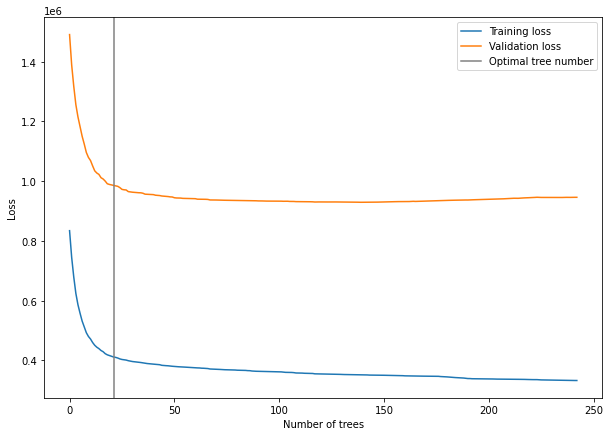

In [448]:
results = xgb_model.evals_result()

plt.figure(figsize=(10,7));
plt.plot(results["validation_0"]["rmse"], label="Training loss");
plt.plot(results["validation_1"]["rmse"], label="Validation loss");
plt.axvline(21, color="gray", label="Optimal tree number");
plt.xlabel("Number of trees");
plt.ylabel("Loss");
plt.legend();

In [449]:
xgb_model.best_ntree_limit

143

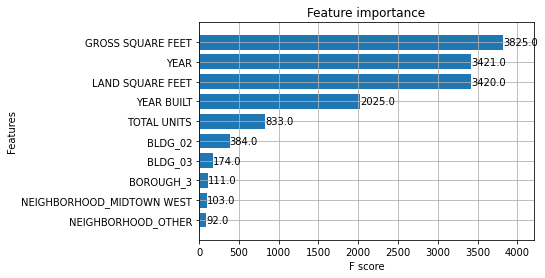

In [475]:
_ = plot_importance(xgb_model, height=0.75, max_num_features=10)

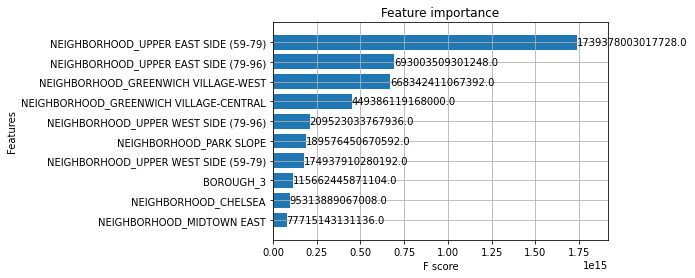

In [476]:
_ = plot_importance(xgb_model, height=0.75, max_num_features=10, importance_type='gain')

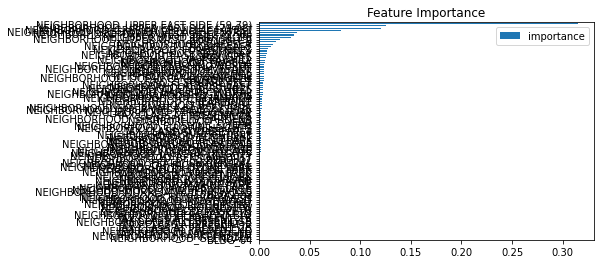

In [470]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [471]:
fi

,importance
YEAR,0.002094
LAND SQUARE FEET,0.001879
GROSS SQUARE FEET,0.004576
YEAR BUILT,0.003070
TOTAL UNITS,0.002319
...,...
NEIGHBORHOOD_WOODHAVEN,0.000764
NEIGHBORHOOD_WOODSIDE,0.000711
BLDG_02,0.001082
BLDG_03,0.000560


In [ ]:
# Use for loop to concatenate the prefixes that are the same